In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random

DEBUG = 'DEBUG'

np.__version__,pd.__version__,sklearn.__version__

('1.22.3', '1.4.2', '1.0.2')

In [2]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

def criaDatasetBlobs(n=1000,n_classes=4,std=0.02):
  X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1.0),cluster_std=0.02)
  return X,y

def criaDatasetXOR(n=100):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y =np.array(y%2,dtype=int)
  return X,y

def criaDatasetNBlobsXOR(n=1000,n_classes=3,std=0.8):
  X,y = make_blobs(n_samples=n,centers=n_classes*2,cluster_std=std)
  y = np.array(y%n_classes,dtype=int)
  return X,y

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)

In [3]:
def define_axes(X,margin=0.1):
  min1,max1 = X[:,0].min(), X[:,0].max()
  min2,max2 = X[:,1].min(), X[:,1].max()
  return [min1 -margin, max1 +margin,min2 -margin,max2 +margin]

    

def plotPredictions(clf,X,y=None,dims=[0,1]):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X_ = np.c_[x0.ravel(),x1.ravel()]
  #print(DEBUG,X_.shape)
  yp = clf.predict(X)
  ypred = clf.predict(X_).reshape(x0.shape)
  if y is not None: print(sum(yp==y)/len(y))
  #print(DEBUG,X_.shape,x0.shape,x1.shape,ypred.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha=0.2)

In [4]:
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize


class ActivationFunction(ABC):
    @abstractstaticmethod
    def fw(a):
        pass
    @abstractstaticmethod
    def bw(a):
        pass
    @abstractstaticmethod
    def cls(a):
        pass

class Tanh(ActivationFunction):
    @staticmethod
    def fw(a):
        return expit(a)*2 -1
    @staticmethod
    def bw(a):
        return (1 - np.square(Tanh.fw(a)))
    @staticmethod
    def cls(a):
        return (a >= 0) * 2 - 1  


class Sigmoid(ActivationFunction):
    @staticmethod
    def fw(a):
        return expit(a)
    @staticmethod
    def bw(a):
        return expit(a) * (1 - expit(a))
    @staticmethod
    def cls(a):
        return (a >= 0.5) * 2 - 1 

class ReLU(ActivationFunction):
    @staticmethod
    def fw(a):
        return a * ( a > 0)
    @staticmethod
    def bw(a):
        return  (a > 0).astype(np.int8)
    @staticmethod
    def cls(a):
        return (a > 0) * 2 - 1  

In [5]:
#w = np.ndarray([[ 1. , -1. ],[ 0.9 , 0.9],[-0.9, -0.9]])
w = np.array([-1,0,1,3,4,5])

Tanh().fw(w)




array([-0.46211716,  0.        ,  0.46211716,  0.90514825,  0.96402758,
        0.9866143 ])

In [6]:
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize


def accuracy(yactual,ypred):
  return sum(yactual==ypred)/len(yactual)


class TrainingAlgorithm(ABC):
  
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversaReg(TrainingAlgorithm):
  def __init__(self,regularization=0,history=[0]):
    self.history = history
    self.regularization = regularization
    
  def getW(self,X,y):
    w = np.linalg.inv(X.T @ X + np.identity(X.shape[1])*self.regularization) @ X.T @ y
    return w

class ELM(BaseEstimator,ClassifierMixin):
  def __init__ (self,n_hidden=10,regularization=0):
    self.n_hidden=n_hidden
    self.regularization = regularization
    self.activation = Tanh().fw
    self.training_algorithm = PseudoInversaReg(regularization=regularization)
    self.wih = None
    self.who = None
  
  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1
  
  def fit(self,X,y):
    Xb = ELM.includeBias(X)
    self.wih = np.random.uniform(-1,1,size=(Xb.shape[1],self.n_hidden)) #-1 a 1 com threshold em 0
    #print(DEBUG,  Xb.shape, self.wih.shape)
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includeBias(H)
    #yhot = self.encode_labels(y)
    self.who = self.training_algorithm.getW(Hb,y)#yhot)  

    return self
  
  def predict(self,X,y=None):
    Xb = ELM.includeBias(X)
    #print(DEBUG,  Xb.shape, self.wih.shape)
    H = self.activation(Xb @ self.wih)
    Hb = ELM.includeBias(H)
    a = Hb @ self.who
    return a
    

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

class FixedWeigths():
  def __init__(self):
    self.n_hidden = 2
    self.activation = Tanh()
    self.training = PseudoInversaReg()

  def fit(self,X,y):
    # Definição manual de pesos
    self.wih = np.array([[1,0.9,-0.9],[-1,0.9,-0.9]]).T
    self.who = np.array([[ 11,-13, 12]]).T

    # Treino somenete da ultima camanda
    #H = self.activation(FixedWeigths.includeBias(X) @ self.wih)
    #Hb = FixedWeigths.includeBias(H) 
    #self.who = self.training.getW(Hb,y)
    print(DEBUG,self.wih)
    print(DEBUG,self.who)
    return self  

  
  def predict(self,X,y=None):
    Xb = FixedWeigths.includeBias(X)
    H = self.activation.fw(Xb @ self.wih)
    Hb = FixedWeigths.includeBias(H)
    return Hb @ self.who
  
  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

class MLP(BaseEstimator,ClassifierMixin):
  def __init__ (self,algorithm=FixedWeigths()):
    self.algorithm = algorithm
  
  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1
  
  def fit(self,X,y):
    yhot = self.encode_labels(y)
    self.algorithm.fit(X,yhot)
    return self
  
  def predict(self,X,y=None):
    a = self.algorithm.predict(X,y)
    
    if len(self.labels) <= 2:
      idx = np.array(a>0,dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a,axis=1)

    ypred = np.array([self.labels[i] for i in idx])
    return ypred  


class Backpropagation():
  def __init__(self,n_hidden=[2],activation=Tanh(),learning_rate=0.001,max_iter=10000,regularization=0):
    self.n_hidden=n_hidden
    self.activation = activation
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.regularization=regularization
    
  def fit(self,X,y):
    self.Ws = []
    if len(self.n_hidden)==0 :
      self.Ws.append(np.random.uniform(-1,1,size=(X[1].shape[1]+1,y.shape[1])))
    else:
      self.Ws.append(np.random.uniform(-1,1,size=(X.shape[1]+1,self.n_hidden[0])))
      for i,_ in enumerate(self.n_hidden):
        if i == len(self.n_hidden)-1:
          self.Ws.append(np.random.uniform(-1,1,size=(self.n_hidden[i]+1,y.shape[1])))
        else:
          self.Ws.append(np.random.uniform(-1,1,size=(self.n_hidden[i]+1,self.n_hidden[i+1])))

    #self.wih = np.random.uniform(-1,1,size=(X.shape[1]+1,self.n_hidden))
    #self.who = np.random.uniform(-1,1,size=(self.n_hidden+1,y.shape[1]))
    for _ in range(self.max_iter):
      self.forward(X)
      self.backward(y)

    return self

  def forward(self,X):
    self.A = []
    self.Z = []
    A = X.copy()
    for i in range(len(self.n_hidden)+1):
      self.A.append(Backpropagation.includeBias(A))
      self.Z.append(self.A[-1] @ self.Ws[i])
      self.py =self.Z[-1]
      A = self.activation.fw(self.Z[-1])
    
    self.ypred = self.activation.cls(A)

    #self.Xb = Backpropagation.includeBias(X)
    #self.pH = self.Xb @ self.wih
    #self.H = self.activation.fw(self.pH)
    #self.Hb = Backpropagation.includeBias(self.H)
    #self.py = self.Hb @ self.who
    #self.posy = self.activation.fw(self.py)
    #self.ypred = self.activation.cls(self.posy)
    return self.ypred
  
  def backward(self,y):
    deltas = [y-self.py]
    grads = [self.A[-1].T @ deltas[-1]]
    for i in range(len(self.n_hidden),0,-1):
      deltas.insert(0,(deltas[0]@self.Ws[i][1:,:].T) *self.activation.bw(self.Z[i-1]) ) #0, deltas[0]@self.Ws[i][1:,:].T])*self.activation.bw(self.Z[i-1]))
      grads.insert(0, self.A[i-1].T @ deltas[0])
    for i in range(len(self.n_hidden),-1,-1):
      self.Ws[i] *= 1 -self.regularization*self.learning_rate
      self.Ws[i] += grads[i]*self.learning_rate



    #ho_delta = y-self.py
    #ho_grad = self.Hb.T @ ho_delta
    ##PULO DO GATO##
    #activation_grad = self.activation.bw(self.pH) #Derivada da função de ativação
    #ih_delta = (ho_delta @ self.who[1:,:].T)*activation_grad  #regra da cadeia f(g(x))'= f'(g(x))*g'(x), removendo o bias do who
    ###############
    #ih_grad = self.Xb.T @ ih_delta
    #self.who += ho_grad * self.learning_rate
    #self.wih += ih_grad * self.learning_rate

    
  def predict(self,X,y=None):
    return self.forward(X)
    
    #Xb = Backpropagation.includeBias(X)
    #H = self.activation.fw(Xb @ self.wih)
    #Hb = Backpropagation.includeBias(H)
    #ypre = Hb @ self.who
    #yact = self.activation.fw(ypre)
    #return self.activation.cls(yact)

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb

DEBUG [[ 1.  -1. ]
 [ 0.9  0.9]
 [-0.9 -0.9]]
DEBUG [[ 11]
 [-13]
 [ 12]]


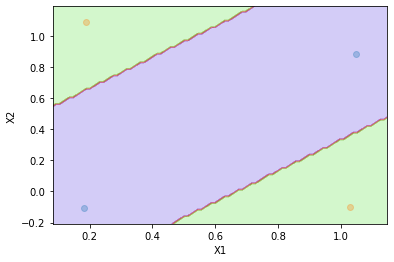

In [7]:
Xtr,ytr = criaDatasetXOR(4)
clf = MLP(algorithm=FixedWeigths())
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)

1.0


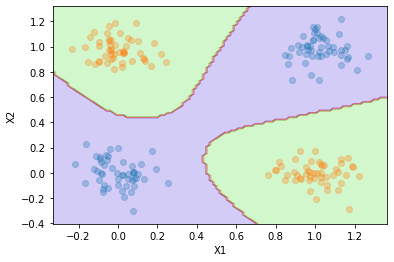

1.0


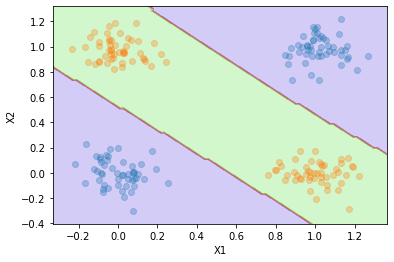

1.0


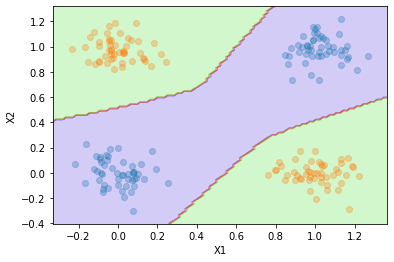

In [8]:
Xtr,ytr = criaDatasetXOR(200)
activation_list = [Tanh(),Sigmoid(),ReLU()]
for act in activation_list:
  clf = MLP(algorithm=Backpropagation(n_hidden=[8,4],activation=act,learning_rate=0.001,max_iter=10000,regularization=0))
  clf.fit(Xtr,ytr)

  #plotPredictions(clf,Xtr)
  #plt.show()

  #Xte,yte = criaDatasetNBlobsXOR(10000)
  #plotDataset(Xte,yte)
  plotDataset(Xtr,ytr)
  plotPredictions(clf,Xtr,ytr)
  plt.show()

0.93


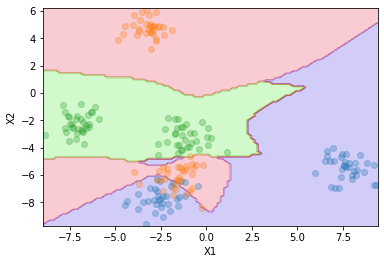

0.83


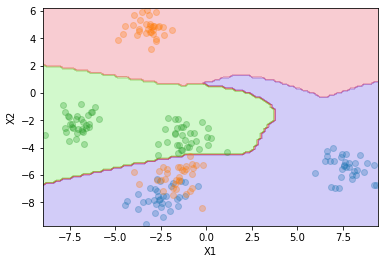

0.945


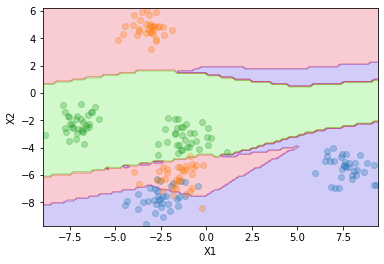

In [36]:
Xtr,ytr = criaDatasetNBlobsXOR(200,n_classes=3)
activation_list = [Tanh(),Sigmoid(),ReLU()]
for act in activation_list:
  clf = MLP(algorithm=Backpropagation(n_hidden=[8,4],activation=act,learning_rate=0.0001,max_iter=10000,regularization=1))
  clf.fit(Xtr,ytr)

  #plotPredictions(clf,Xtr)
  #plt.show()

  #Xte,yte = criaDatasetNBlobsXOR(10000)
  #plotDataset(Xte,yte)
  plotDataset(Xtr,ytr)
  plotPredictions(clf,Xtr,ytr)
  plt.show()

0.945


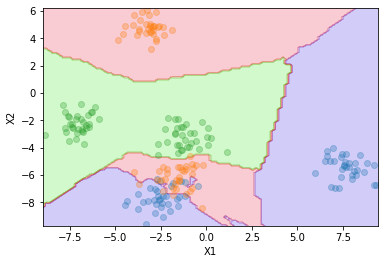

In [37]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtr,ytr)

#plotPredictions(clf,Xtr)
#plt.show()

#Xte,yte = criaDatasetNBlobsXOR(10000)
#plotDataset(Xte,yte)
plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr,ytr)


# MLP Keras

In [38]:
import tensorflow as tf
from tensorflow import keras
import gc

from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
#from tensorflow.keras.datasets import fashion_mnist
#from tqdm.keras import TqdmCallback

DEBUG = 'DEBUG: '

tf.keras.backend.clear_session()
gc.collect()

def disable_gpu_tf():
  try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(DEBUG,visible_devices)
        assert device.device_type != 'GPU'
  except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass

print(DEBUG,tf.config.get_visible_devices())
disable_gpu_tf()

DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [58]:
class MLPKeras(BaseEstimator,ClassifierMixin):
  def __init__(self,max_iter=1000,n_hidden=[5,4]):
    self.max_iter = max_iter
    self.n_hidden = n_hidden

  def fit(self,X,y):
    self.labels,ids = np.unique(y,return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = keras.models.Sequential()
    self.model.add(keras.layers.InputLayer(input_shape=(X.shape[1],)))
    
    for i,h in enumerate(self.n_hidden):
      #print(DEBUG,i,h)
      self.model.add(keras.layers.Dense(h))
      if i<len(self.n_hidden)-1:
        self.model.add(keras.layers.Activation('relu'))

    self.model.add(keras.layers.Activation('relu'))
    self.model.add(keras.layers.Dense(yhot.shape[1]))
    self.model.add(keras.layers.Activation('softmax'))    
    self.model.compile(loss='categorical_crossentropy')
    self.model.fit(X,yhot,epochs=self.max_iter,verbose=0)
  
  def predict(self,X):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]

0.93


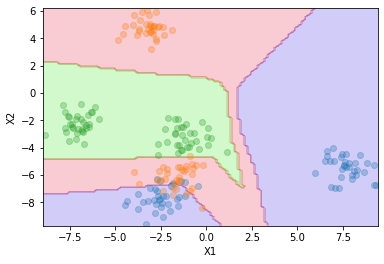

In [61]:
from sklearn.neighbors import KNeighborsClassifier
#Xtr,ytr = criaDatasetXOR(200)
clf = MLPKeras(max_iter=1000,n_hidden=[5,4])
clf.fit(Xtr,ytr)

#plotPredictions(clf,Xtr)
#plt.show()

#Xte,yte = criaDatasetNBlobsXOR(10000)
#plotDataset(Xte,yte)
plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr,ytr)